# Transfer learning from Colin's original model

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
# imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight

# User inputs

In [39]:
tf.config.list_physical_devices('GPU')
tf.test.is_gpu_available()

True

In [40]:
# getting directories
colins_model_path = "G:/Shared drives/BioSoundSCape_ABG/ABGQI-CNN-v.1.0.1/CQuinn8-ABGQI-CNN-93420d1/1_cnn_training-py/results/ABGQI-CNN"
train_path = "G:/Shared drives/BioSoundSCape_ABG/code/train_labels.csv"
val_path = "G:/Shared drives/BioSoundSCape_ABG/code/val_labels.csv"
test_path = "G:/Shared drives/BioSoundSCape_ABG/code/test_labels.csv"

# Creating training dataframe

In [41]:
# load in train csv
train_df = pd.read_csv(train_path)
train_df

,img_path,label,group
0,G:/Shared drives/BioSoundSCape_ABG/labeled_dat...,1,584
1,G:/Shared drives/BioSoundSCape_ABG/labeled_dat...,1,595
2,G:/Shared drives/BioSoundSCape_ABG/labeled_dat...,1,596
3,G:/Shared drives/BioSoundSCape_ABG/labeled_dat...,1,584
4,G:/Shared drives/BioSoundSCape_ABG/labeled_dat...,1,593
...,...,...,...
11039,G:/Shared drives/BioSoundSCape_ABG/labeled_dat...,1,16
11040,G:/Shared drives/BioSoundSCape_ABG/labeled_dat...,1,17
11041,G:/Shared drives/BioSoundSCape_ABG/labeled_dat...,1,17
11042,G:/Shared drives/BioSoundSCape_ABG/labeled_dat...,1,17


label
0    1867
1    6298
2    1580
3    1299
Name: count, dtype: int64


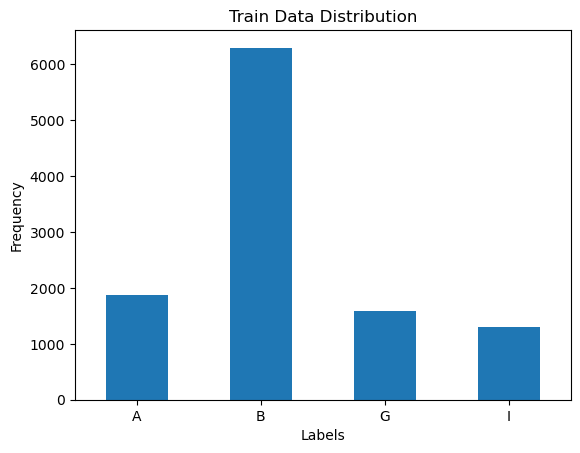

In [42]:
# show train distribution
train_label_counts = train_df['label'].value_counts().sort_index()
print(train_label_counts)

train_dist = train_label_counts.plot(kind='bar', title='Train Data Distribution')
train_dist.set_xticks([0, 1, 2, 3])
train_dist.set_xticklabels(['A', 'B', 'G', 'I'])
train_dist.set_xlabel('Labels')
train_dist.set_ylabel('Frequency')

plt.xticks(rotation=0) # change x labels to be horizontal
plt.show()

In [43]:
# check all images exist
for image_path in train_df['img_path'].to_numpy():
  assert os.path.exists(image_path), "ERROR - IMAGE PATH NOT FOUND - " + str(image_path)

print('all training images exist')

all training images exist


C:\Users\kathy\AppData\Local\Temp\ipykernel_9964\669174094.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_samples = train_df.groupby(['label']).apply(pd.DataFrame.sample, n=1).reset_index(drop=True)


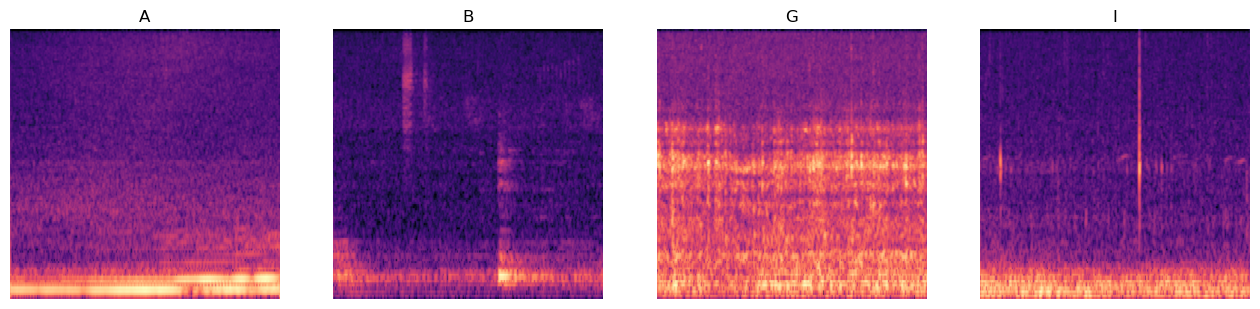

In [44]:
# show sample spectrogram of each category
train_samples = train_df.groupby(['label']).apply(pd.DataFrame.sample, n=1).reset_index(drop=True)

plt.figure(figsize=(16, 4))
for i, row in train_samples.iterrows():
  ax = plt.subplot(1, 4, i+1)
  img = mpimg.imread(row['img_path'])
  plt.imshow(img)

  if (str(row['label']) == '0'):
    plt.title('A')
  elif (str(row['label']) == '1'):
    plt.title('B')
  elif (str(row['label']) == '2'):
    plt.title('G')
  elif (str(row['label']) == '3'):
    plt.title('I')

  plt.axis('off')

# Creating validation dataframe

In [45]:
# load in validation csv
val_df = pd.read_csv(val_path)
val_df

,img_path,label,group
0,G:/Shared drives/BioSoundSCape_ABG/labeled_dat...,1,19
1,G:/Shared drives/BioSoundSCape_ABG/labeled_dat...,1,20
2,G:/Shared drives/BioSoundSCape_ABG/labeled_dat...,1,20
3,G:/Shared drives/BioSoundSCape_ABG/labeled_dat...,1,20
4,G:/Shared drives/BioSoundSCape_ABG/labeled_dat...,1,21
...,...,...,...
1054,G:/Shared drives/BioSoundSCape_ABG/labeled_dat...,1,18
1055,G:/Shared drives/BioSoundSCape_ABG/labeled_dat...,1,18
1056,G:/Shared drives/BioSoundSCape_ABG/labeled_dat...,1,18
1057,G:/Shared drives/BioSoundSCape_ABG/labeled_dat...,1,19


label
0    155
1    604
2    150
3    150
Name: count, dtype: int64


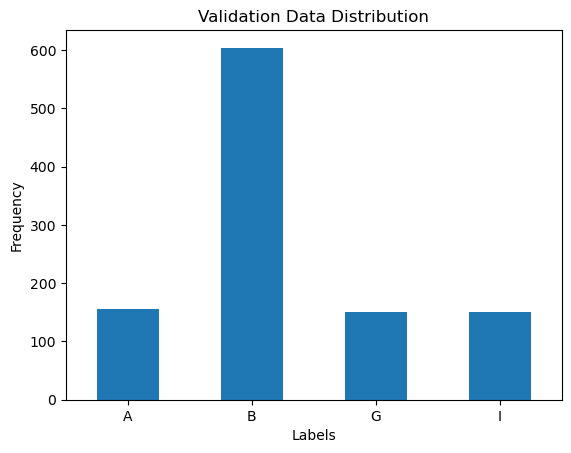

In [46]:
# show validation distribution
val_label_counts = val_df['label'].value_counts().sort_index()
print(val_label_counts)

val_dist = val_label_counts.plot(kind='bar', title='Validation Data Distribution')
val_dist.set_xticks([0, 1, 2, 3])
val_dist.set_xticklabels(['A', 'B', 'G', 'I'])
val_dist.set_xlabel('Labels')
val_dist.set_ylabel('Frequency')

plt.xticks(rotation=0) # change x labels to be horizontal
plt.show()

In [47]:
# check all images exist
for image_path in val_df['img_path'].to_numpy():
  assert os.path.exists(image_path), "ERROR - IMAGE PATH NOT FOUND - " + str(image_path)

print('all validation images exist')

all validation images exist


C:\Users\kathy\AppData\Local\Temp\ipykernel_9964\1691758754.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  val_samples = val_df.groupby(['label']).apply(pd.DataFrame.sample, n=1).reset_index(drop=True)


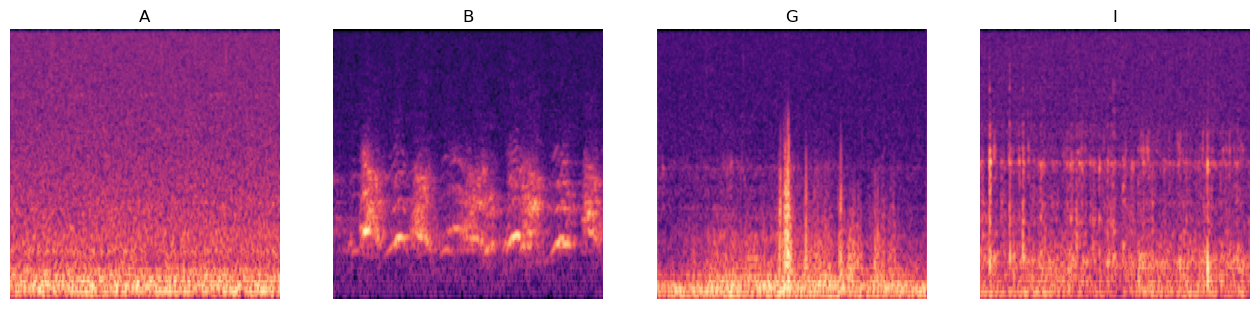

In [48]:
# show sample spectrogram of each category
val_samples = val_df.groupby(['label']).apply(pd.DataFrame.sample, n=1).reset_index(drop=True)

plt.figure(figsize=(16, 4))
for i, row in val_samples.iterrows():
  ax = plt.subplot(1, 4, i+1)
  img = mpimg.imread(row['img_path'])
  plt.imshow(img)

  if (str(row['label']) == '0'):
    plt.title('A')
  elif (str(row['label']) == '1'):
    plt.title('B')
  elif (str(row['label']) == '2'):
    plt.title('G')
  elif (str(row['label']) == '3'):
    plt.title('I')

  plt.axis('off')

# Creating testing dataframe

In [49]:
# load in test csv
test_df = pd.read_csv(test_path)
test_df

,img_path,label,group
0,G:/Shared drives/BioSoundSCape_ABG/labeled_dat...,1,19
1,G:/Shared drives/BioSoundSCape_ABG/labeled_dat...,1,20
2,G:/Shared drives/BioSoundSCape_ABG/labeled_dat...,1,20
3,G:/Shared drives/BioSoundSCape_ABG/labeled_dat...,1,20
4,G:/Shared drives/BioSoundSCape_ABG/labeled_dat...,1,21
...,...,...,...
1053,G:/Shared drives/BioSoundSCape_ABG/labeled_dat...,1,18
1054,G:/Shared drives/BioSoundSCape_ABG/labeled_dat...,1,18
1055,G:/Shared drives/BioSoundSCape_ABG/labeled_dat...,1,18
1056,G:/Shared drives/BioSoundSCape_ABG/labeled_dat...,1,19


label
0    158
1    601
2    149
3    150
Name: count, dtype: int64


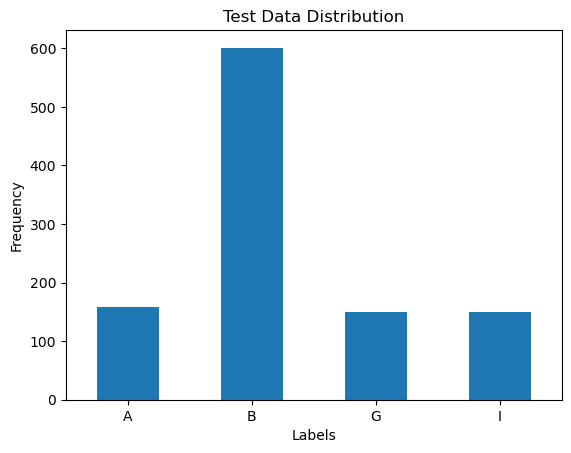

In [50]:
# show test distribution
test_label_counts = test_df['label'].value_counts().sort_index()
print(test_label_counts)

test_dist = test_label_counts.plot(kind='bar', title='Test Data Distribution')
test_dist.set_xticks([0, 1, 2, 3])
test_dist.set_xticklabels(['A', 'B', 'G', 'I'])
test_dist.set_xlabel('Labels')
test_dist.set_ylabel('Frequency')

plt.xticks(rotation=0) # change x labels to be horizontal
plt.show()

In [51]:
# check all images exist
for image_path in test_df['img_path'].to_numpy():
  assert os.path.exists(image_path), "ERROR - IMAGE PATH NOT FOUND - " + str(image_path)

print('all test images exist')

all test images exist


C:\Users\kathy\AppData\Local\Temp\ipykernel_9964\3681097128.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_samples = test_df.groupby(['label']).apply(pd.DataFrame.sample, n=1).reset_index(drop=True)


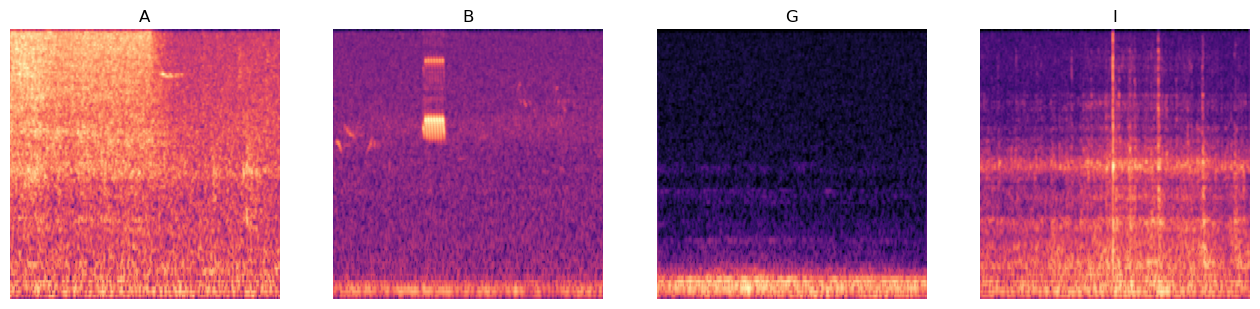

In [52]:
# show sample spectrogram of each category
test_samples = test_df.groupby(['label']).apply(pd.DataFrame.sample, n=1).reset_index(drop=True)

plt.figure(figsize=(16, 4))
for i, row in test_samples.iterrows():
  ax = plt.subplot(1, 4, i+1)
  img = mpimg.imread(row['img_path'])
  plt.imshow(img)

  if (str(row['label']) == '0'):
    plt.title('A')
  elif (str(row['label']) == '1'):
    plt.title('B')
  elif (str(row['label']) == '2'):
    plt.title('G')
  elif (str(row['label']) == '3'):
    plt.title('I')

  plt.axis('off')

# Over-sampling

In [53]:
def oversample_class (df, target_size):
    seed = 0
    
    # check if sampling needs to be done
    if len(df) == target_size:
        return df

    # randomly oversample the dataframe
    bal_df = df.sample(target_size, replace=True, random_state=seed)
    return bal_df    

In [55]:
def oversample (df, lbl_col='label'):
    # get a list of all of the classes
    classes = df[lbl_col].unique()

    # find the maximum class size
    target_size = max(df[lbl_col].value_counts())

    # define a list to hold the oversampled dataframes
    samples = []

    # iterate through each class
    for lbl in classes:
        # extract all rows of df which have the current label
        subset_df = df.loc[df[lbl_col] == lbl]

        # oversample that dataframe and add it to the list
        oversampled_df = oversample_class(subset_df, target_size)
        samples.append(oversampled_df)

    # concatenate all of the dataframes together
    bal_df = pd.concat(samples, axis=0)
    bal_df = bal_df.reset_index(drop=True)
    return bal_df

In [56]:
# oversample train dataframe
train_df = oversample(train_df)
train_df

,img_path,label,group
0,G:/Shared drives/BioSoundSCape_ABG/labeled_dat...,1,584
1,G:/Shared drives/BioSoundSCape_ABG/labeled_dat...,1,595
2,G:/Shared drives/BioSoundSCape_ABG/labeled_dat...,1,596
3,G:/Shared drives/BioSoundSCape_ABG/labeled_dat...,1,584
4,G:/Shared drives/BioSoundSCape_ABG/labeled_dat...,1,593
...,...,...,...
25187,G:/Shared drives/BioSoundSCape_ABG/labeled_dat...,3,3091
25188,G:/Shared drives/BioSoundSCape_ABG/labeled_dat...,3,3077
25189,G:/Shared drives/BioSoundSCape_ABG/labeled_dat...,3,3151
25190,G:/Shared drives/BioSoundSCape_ABG/labeled_dat...,3,3084


label
0    6298
1    6298
2    6298
3    6298
Name: count, dtype: int64


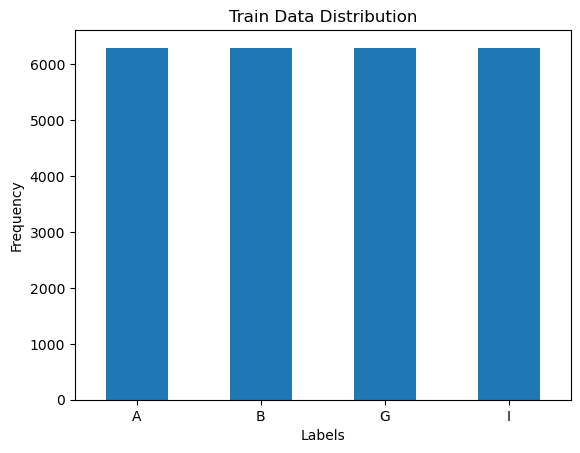

In [57]:
# show oversampled train distribution
oversampled_train_label_counts = train_df['label'].value_counts().sort_index()
print(oversampled_train_label_counts)

oversampled_train_dist = oversampled_train_label_counts.plot(kind='bar', title='Train Data Distribution')
oversampled_train_dist.set_xticks([0, 1, 2, 3])
oversampled_train_dist.set_xticklabels(['A', 'B', 'G', 'I'])
oversampled_train_dist.set_xlabel('Labels')
oversampled_train_dist.set_ylabel('Frequency')

plt.xticks(rotation=0) # change x labels to be horizontal
plt.show()

In [59]:
# check all images exist
for image_path in train_df['img_path'].to_numpy():
  assert os.path.exists(image_path), "ERROR - IMAGE PATH NOT FOUND - " + str(image_path)

print('all training images exist')

all training images exist


# Functions to set up images for training

In [60]:
# dataset parameters
BATCH_SIZE = 16
IMG_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE

def make_ds (df):
  #make the initial dataset object
  paths = df['img_path'].to_numpy()
  labels = df['label'].to_numpy()
  ds = tf.data.Dataset.from_tensor_slices((paths, labels))
  return ds

# function to read in a file path and resizes it
def prepare_image(file_path, label):
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = tf.image.decode_image(img, channels=3, expand_animations=False)
  img = tf.image.resize(img, IMG_SIZE)
  return img, label

# configure dataset to increase performance
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [61]:
# make dataset
train_ds = make_ds(train_df)
val_ds = make_ds(val_df)
test_ds = make_ds(test_df)

# prepare the images
train_ds = train_ds.map(prepare_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(prepare_image, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(prepare_image, num_parallel_calls=AUTOTUNE)

# configure the datasets to increase performance
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

In [62]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# Load old model for transfer learning

In [81]:
# LOAD MODEL
model = tf.keras.models.load_model(colins_model_path)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.40_224 (Funct  (None, 7, 7, 1792)       4363712   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1792)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 8965      
                                                                 
Total params: 4,372,677
Trainable params: 8,965
Non-trainable params: 4,363,712
_________________________________________________________________


In [82]:
modified_model = model

# allow mobile net layer to be trainable
mobilenet_layer = modified_model.layers[0]
mobilenet_layer.trainable = True

# freeze some layers of mobilenet total of 155 layers
for layer in mobilenet_layer.layers[:150]:
    layer.trainable = False

# remove last layer of old model
modified_model.pop()

modified_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.40_224 (Funct  (None, 7, 7, 1792)       4363712   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1792)             0         
 lobalAveragePooling2D)                                          
                                                                 
Total params: 4,363,712
Trainable params: 1,409,408
Non-trainable params: 2,954,304
_________________________________________________________________


In [83]:
# compile new model
new_model = Sequential([
    modified_model,
    #layers.Dense(1792, activation=tf.keras.activations.relu),
    #layers.Dropout(0.5),
    #layers.Dense(896, activation=tf.keras.activations.relu),
    #layers.Dropout(0.5),
    layers.Dense(4, activation=tf.keras.activations.sigmoid, name="output_layer")
])
new_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 1792)              4363712   
                                                                 
 output_layer (Dense)        (None, 4)                 7172      
                                                                 
Total params: 4,370,884
Trainable params: 1,416,580
Non-trainable params: 2,954,304
_________________________________________________________________


In [84]:
# compile the model
new_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Calculate class weights

In [50]:
def getClassWeights (classes, y):
    class_weights = compute_class_weight('balanced', classes=classes, y=y)
    return dict(enumerate(class_weights))

In [51]:
class_weights = getClassWeights(train_df['label'].unique(), train_df['label'].to_numpy())
class_weights

{0: 0.44854417670682734,
 1: 2.0635103926097,
 2: 1.4357257632565614,
 3: 1.696518987341772}

In [85]:
# callback functions
earlystopping = tf.keras.callbacks.EarlyStopping(patience=3, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=.5,
    patience=3,
    verbose=1,
    min_lr=0.000001
)

In [86]:
# train model
result_new_model = new_model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    #class_weight=class_weights,
    callbacks=[reduce_lr]
)

Epoch 1/10
1575/1575 [==============================] - 105s 64ms/step - loss: 0.0807 - accuracy: 0.9784 - val_loss: 11.7346 - val_accuracy: 0.1454 - lr: 1.0000e-04
Epoch 2/10
1575/1575 [==============================] - 95s 60ms/step - loss: 0.0894 - accuracy: 0.9780 - val_loss: 7.0940 - val_accuracy: 0.1832 - lr: 1.0000e-04
Epoch 3/10
1575/1575 [==============================] - 94s 60ms/step - loss: 0.0649 - accuracy: 0.9825 - val_loss: 10.3274 - val_accuracy: 0.1473 - lr: 1.0000e-04
Epoch 4/10
1575/1575 [==============================] - 99s 63ms/step - loss: 0.0543 - accuracy: 0.9844 - val_loss: 4.9073 - val_accuracy: 0.2276 - lr: 1.0000e-04
Epoch 5/10
1575/1575 [==============================] - 94s 60ms/step - loss: 0.0429 - accuracy: 0.9868 - val_loss: 6.9880 - val_accuracy: 0.1926 - lr: 1.0000e-04
Epoch 6/10
1575/1575 [==============================] - 95s 61ms/step - loss: 0.0368 - accuracy: 0.9880 - val_loss: 5.6174 - val_accuracy: 0.1889 - lr: 1.0000e-04
Epoch 7/10
1574/157

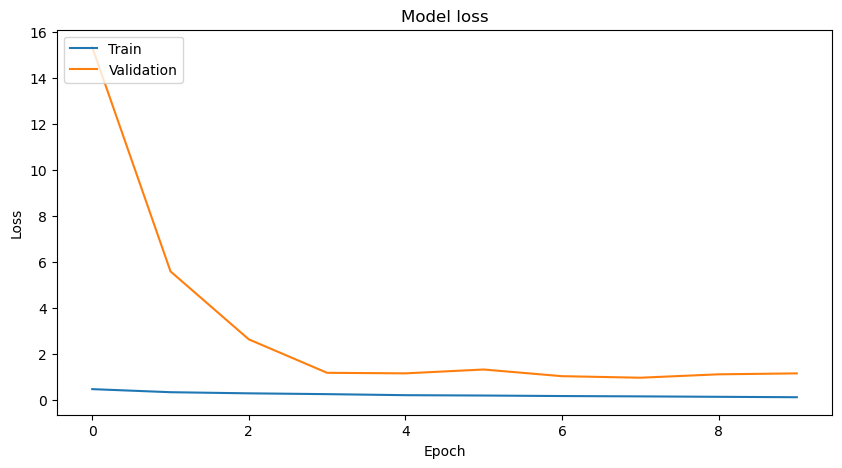

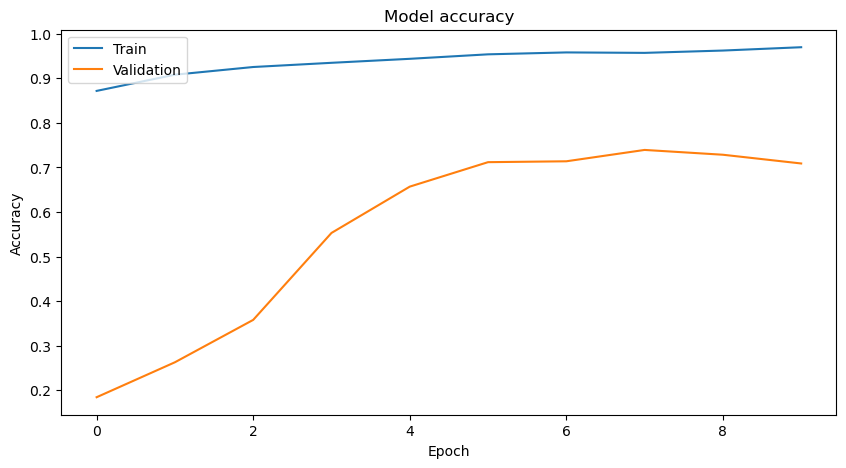

In [45]:
# Assuming `history` contains the result from model fitting
history = result_new_model.history

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [113]:
test_results = new_model.predict(test_ds)

63/63 [==============================] - 6s 78ms/step


In [114]:
test_results

array([[2.2112418e-04, 9.9999940e-01, 3.7143210e-01, 3.4754246e-02],
       [1.4119772e-03, 9.9999154e-01, 2.1053021e-01, 9.7420581e-02],
       [9.5347119e-03, 9.8233032e-01, 9.5019871e-01, 1.7884094e-01],
       ...,
       [1.3507286e-04, 1.0000000e+00, 9.8255863e-03, 3.2154281e-02],
       [2.0557120e-04, 1.0000000e+00, 2.9609993e-03, 1.0827030e-02],
       [4.2460763e-04, 9.9999976e-01, 4.2637359e-02, 7.0612617e-02]],
      dtype=float32)

In [115]:
sigmoid_test_results = tf.math.sigmoid(test_results).numpy()
sigmoid_test_results

array([[0.50005525, 0.7310585 , 0.591805  , 0.5086877 ],
       [0.500353  , 0.73105687, 0.55243903, 0.5243359 ],
       [0.50238365, 0.72757035, 0.72115517, 0.5445915 ],
       ...,
       [0.5000338 , 0.73105854, 0.50245637, 0.5080379 ],
       [0.5000514 , 0.73105854, 0.50074023, 0.50270677],
       [0.50010616, 0.7310585 , 0.5106577 , 0.51764584]], dtype=float32)

In [116]:
test_img_path = "G:/Shared drives/BioSoundSCape_ABG/labeled_data/spectrogram_data/test/"
sigmoid_output_path = "G:/Shared drives/BioSoundSCape_ABG/code/results/sigmoid_outputs.csv"

# dimensions of our images    
img_width, img_height, img_depth = 224, 224, 3 # 224 pixels x 224 pixels x 3 bands (RGB)

In [117]:
# function to read in a file path
def process_path(file_path, IMG_HEIGHT, IMG_WIDTH):
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img, IMG_HEIGHT, IMG_WIDTH)
    return img #, label

# function that interpretes image after being provided a path in process_path
def decode_img(img, IMG_HEIGHT, IMG_WIDTH):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

In [118]:
sigmoid_pred_list = []
img_label_list = []
img_group_list = []

# iterate through each directory (class or wav dir with mfccs within)
for i, img in enumerate(os.listdir(test_img_path)):
    
    #print(img, i)   
    img_data = img.split('.')[1] # grab only the part that has information
    #print(img_data)

    img_data = img_data.split('_') # split up img data
    #print(img_data)
    img_label = img_data[2]
    img_group = img_data[-1]
    #print(out_dir)
    #print("Number of pngs", len(img)) 
    
        
    # enter prediction 
    # process image
    img_path = test_img_path + img
    img_ = process_path(img_path, IMG_HEIGHT = img_height, IMG_WIDTH = img_width)
    img_ = tf.reshape(img_, shape= (1, img_height, img_width, img_depth))
        
    # get predictions
    pred = new_model.predict(img_, verbose=0, steps=1, callbacks=None, max_queue_size=10, 
            use_multiprocessing=False)

    #print(pred)
    sigmoid_pred = pred
    sigmoid_pred = sigmoid_pred.tolist()
    for list in sigmoid_pred:
        if img_label == 'A':
            img_label = 0
        elif img_label == 'B':
            img_label = 1
        elif img_label == 'G':
            img_label = 2
        elif img_label == "I":
            img_label = 3

        list.append(img_label)
        list.append(img_group)
        sigmoid_pred_list.append(list)
    
      
    # save label preds
    #flat_sigmoid = [item for sublist in sigmoid_pred_lst for item in sublist]
    #df_sigmoid = pd.DataFrame(flat_sigmoid)
    #df_sigmoid.columns = ["Anthrophony", "Biophony", "Geophony", "Interference"]
    #df_sigmoid["IMG Label"] = img_label
    
# write directory csv 
new_pd = pd.DataFrame(data=sigmoid_pred_list, columns=["Anthrophony", "Biophony", "Geophony", "Interference", "IMG label", "IMG group"])
#new_pd["IMG Label"] = img_label_list
#new_pd["IMG Group"] = img_group_list
#new_pd.to_csv(sigmoid_output_path, index=False)


In [119]:
new_pd.to_csv(sigmoid_output_path, index=False)

In [87]:
img_label_list

['B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'G',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'G',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'G',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'B',
 'G',
 'B',
 'B',
 'G',
 'G',
 'B',
 'B'